In [1]:
import os
os.environ['OMP_NUM_THREADS']='4'

import numpy as np
import reaktoro as rkt
from dolfin import *
from dolfin import sqrt, jump, avg
import dolfin
from ufl.classes import MaxValue
from ufl.algebra import Abs

import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

import sys
sys.path.insert(0, '/home/powei/projects/reaktoro_transport-git')
from reaktoro_transport.solver import multicomponent_diffusion_problem
#from reaktoro_transport.solver import reactive_transport_problem_base
#from reaktoro_transport.solver.reactive_transport_problem_base import reactive_transport_problem_base
import reaktoro_transport.tools as tools

%matplotlib notebook
%matplotlib notebook
plt.rcParams.update({'font.size': 18})
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
plt.rcParams.update({'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']})

In [49]:
def darcy_uzawa(mesh, boundary_markers, rho, K, boundary_dict, p_list=[1.0]\
                 , max_steps=500, res_target=1e-12, omega_num=1.0, r_num=0.0):
    # The Augmented Lagrangian method is implemented.
    # When r_num=0, converges for omega_num < 2. (Try 1.5 first)
    # For 0 < omega < 2r, the augmented system converges. r>>1

    V = FunctionSpace(mesh, "BDM", 1)
    Q = FunctionSpace(mesh, "DG", 0)

    # Define trial and test functions
    u = TrialFunction(V)
    p = TrialFunction(Q)
    v = TestFunction(V)
    q = TestFunction(Q)

    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
    dS = Measure('dS', domain=mesh, subdomain_data=boundary_markers)

    bcu = []
    bcp = []

    if mesh.geometric_dimension()==2:
        noslip = (0.0, 0.0)
    elif mesh.geometric_dimension()==3:
        noslip = (0.0, 0.0, 0.0)

    for idx in boundary_dict['noslip']:
        bcu.append(DirichletBC(V, noslip, boundary_markers, idx))

    # Create functions
    u0 = Function(V)
    u1 = Function(V)
    v0 = Function(V) # Test function used for residual calculations
    for bc in bcu:
        bc.apply(v0.vector())

    p0 = Function(Q)
    p1 = Function(Q)

    p0 = project(Expression('0.0', degree=0), Q)
    
    g = as_vector([0.0, -9806.65])

    # Define coefficients
    f = Constant((0, 0))
    mu = Constant(8.9e-4)
    
    one = Constant(1.0)
    r = Constant(r_num)
    omega = Constant(omega_num)
    h = CellDiameter(mesh)

    nn = FacetNormal(mesh)
    h_avg = (h('+') + h('-'))/2.0

    # Tentative velocity step
    F1 = mu/K*inner(v, u)*dx - inner(p0, div(v))*dx \
         - inner(v, rho*g)*dx \
         + r*inner(div(v), div(u))*dx # grad-div stabilization

    for i, p_dirichlet in enumerate(p_list):
         F1 += Constant(p_dirichlet)*inner(nn, v)*ds(boundary_dict['inlet'][i])

    a1 = lhs(F1)
    L1 = rhs(F1)

    # Assemble matrices
    A1 = assemble(a1)

    # Pressure update
    #a2 = q*p*dx  + omega*(2.0 - (phi('+') + phi('-')))*h_avg**2*dot(jump(q), jump(p))*dS
    a2 = q*p*dx #+ omega*h_avg*dot(jump(q), jump(p))*dS(0) #beta = 1.0
    L2 = q*p0*dx - omega*q*div(u1)*dx

#     a2 = q*p*dx
#     L2 = q*p0*dx - omega*q*div(u1)*dx + omega*h_avg*dot(jump(q), jump(p0))*dS

#     a2 = omega*h_avg*dot(jump(q), jump(p))*dS #beta = 1.0
#     L2 = phi_DG*omega*inner(grad(q), u1)*dx

    A2 = assemble(a2)

    u_list = []
    p_list = []
    res_list = []

    solver1 = PETScKrylovSolver('gmres', 'amg')
    solver2 = PETScKrylovSolver('gmres', 'amg')

    prm = solver1.parameters

    prm['absolute_tolerance'] = 1e-14
    #prm['ksp_converged_reason'] = True
    prm['relative_tolerance'] = 1e-12
    prm['maximum_iterations'] = 5000
    prm['error_on_nonconvergence'] = True
    prm['monitor_convergence'] = True
    prm['nonzero_initial_guess'] = True

    prm = solver2.parameters

    prm['absolute_tolerance'] = 1e-14
    #prm['ksp_converged_reason'] = True
    prm['relative_tolerance'] = 1e-12
    prm['maximum_iterations'] = 5000
    prm['error_on_nonconvergence'] = True
    prm['monitor_convergence'] = True
    prm['nonzero_initial_guess'] = True

    #pout = File("Box_p_iter.pvd")
    #vout = File("Box_v_iter.pvd")

    xdmf_obj = XDMFFile(MPI.comm_world, 'pv_output.xdmf')

    residual = 1.0
    i = 0

    #for i in range(steps):
    while(np.abs(residual) > res_target):
        # Compute tentative velocity step
        begin("Computing tentative velocity")
        b1 = assemble(L1)
        [bc.apply(A1, b1) for bc in bcu]
        solver1.solve(A1, u1.vector(), b1)
        end()

        # Pressure correction
        begin("Computing pressure correction")
        b2 = assemble(L2)
        #[bc.apply(A2, b2) for bc in bcp]
        solver2.solve(A2, p1.vector(), b2)
        end()

        #div_u1 = project(div(u1), Q)
        #p1.vector()[:] = p0.vector()[:] - omega_num*div_u1.vector()[:]

        p_diff = assemble((p1-p0)**2*dx)**0.5
        div_u = assemble(q*div(u1)*dx).norm('l2')
        residual_form = (inner(v0, u1) - p1*div(v0))*dx
        for i, p_dirichlet in enumerate(p_list):
             residual_form += Constant(p_dirichlet)*inner(nn, v0)*ds(boundary_dict['inlet'][i])\
                              - dot(nn, dot(grad(u), v0))*ds(boundary_dict['inlet'][i])
        residual = assemble(residual_form) + div_u

        u0.assign(u1)
        p0.assign(p1)

        if MPI.rank(MPI.comm_world)==0:
            #print(div_u, p_diff)
            res_list.append(residual)

        i+=1
        #xdmf_obj.write(u0, i)
        #xdmf_obj.write(p0, i)

        if (i>=max_steps):
            if MPI.rank(MPI.comm_world)==0:
                print('Reached maximum steps! Saving progress...')
            break

    # Only saving the last time step
    xdmf_obj.write(u0, i)
    xdmf_obj.write(p0, i)

    xdmf_obj.close()

    if MPI.rank(MPI.comm_world)==0:
        #u_list.append(u0.copy())
        #p_list.append(p0.copy())
        print(div_u, p_diff)
        print('Used  ', i, ' steps to converge!')

    return u0.copy(), p0.copy(), res_list

In [72]:
help(Function.rename)

Help on function rename in module dolfin.function.function:

rename(self, name, s)



In [71]:
mesh_2d = RectangleMesh.create([Point(0.0, 0.0), Point(31.0, 50.0)], [21, 41], CellType.Type.triangle, 'right/left')
boundary_markers = MeshFunction('size_t', mesh_2d, dim=1)

DG_space = FunctionSpace(mesh_2d, 'DG', 0)
#rho = project(Expression('x[1]', degree=1), DG_space)
rho = project(Expression('1e-3', degree=1), DG_space)
K = project(Expression('1.0/12.0', degree=1), DG_space)

boundary_markers.set_all(0)

class left(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0, DOLFIN_EPS)
    
class right(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 31.0, DOLFIN_EPS)
    
class bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0, DOLFIN_EPS)

class top(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 50.0, DOLFIN_EPS)

class boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary
    
b_left = left()
b_right = right()
b_bottom = bottom()
b_top = top()
b_boundary = boundary()

# Boundary on the fluid domain is marked as 0
boundary_markers.set_all(0)

# Then Mark boundaries
b_right.mark(boundary_markers, 1)
b_top.mark(boundary_markers, 2)
b_left.mark(boundary_markers, 3)
b_bottom.mark(boundary_markers, 4)

f_7069


In [45]:
# Defining the inlet and noslip boundary markers
b_dict = {'inlet': [], 'noslip': [1, 2, 3, 4], }
p_dirichlet_list = []

In [68]:
%%time
# The augmented Lagrangian method
u, p, res_list = darcy_uzawa(mesh_2d, boundary_markers, rho, K, b_dict, \
                                            p_dirichlet_list, max_steps=30, res_target=1e-10, omega_num=10.0, r_num=10.0)

Reached maximum steps! Saving progress...
3.3274931156161106e-10 0.0
Used   30  steps to converge!
CPU times: user 8.3 s, sys: 56.8 ms, total: 8.36 s
Wall time: 8.34 s


348.69339174964273


<IPython.core.display.Javascript object>


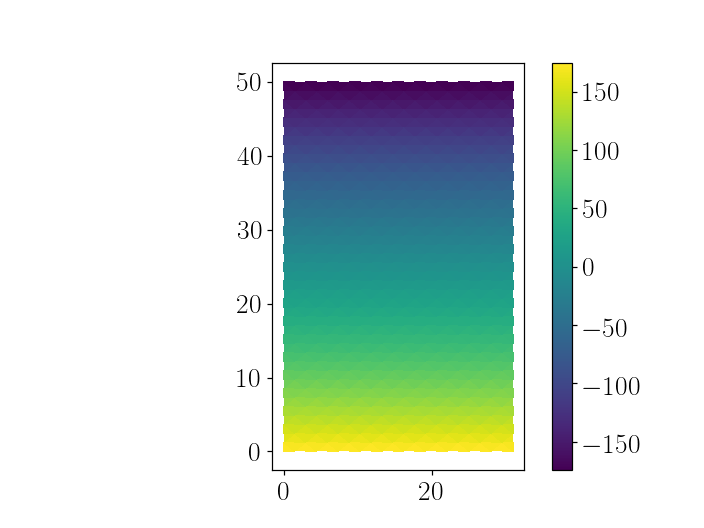

In [66]:
print(max(p.vector()[:]) - min(p.vector()[:]))
fig = plt.figure()
cb = plot(p)
fig.colorbar(cb)
plt.show()

<IPython.core.display.Javascript object>


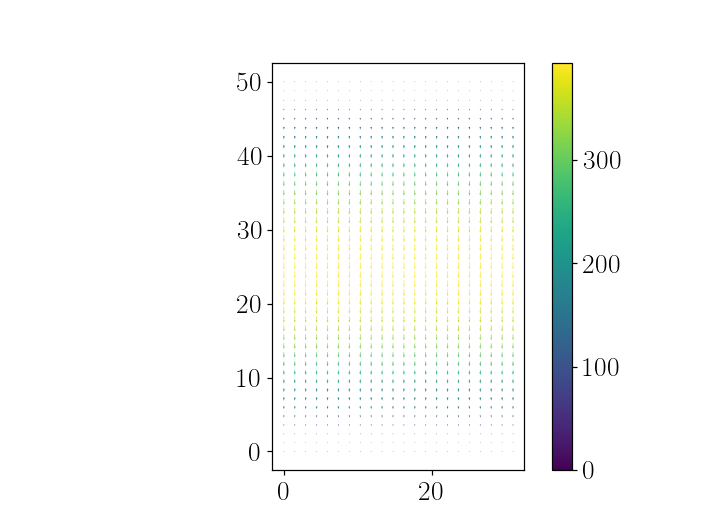

In [67]:
fig = plt.figure()
cb = plot(u)
fig.colorbar(cb)
plt.show()

<IPython.core.display.Javascript object>


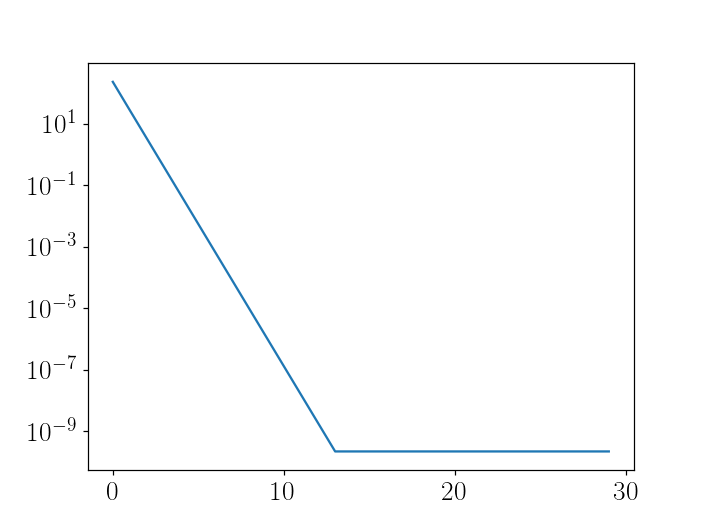

In [63]:
plt.figure()
plt.plot(res_list)
plt.semilogy()
plt.show()

In [8]:
def steady_darcy_flow(mesh, boundary_markers, rho, dt_num, steps):
    RT = FiniteElement('BDM', mesh.cell_name(), 1)
    #RT = VectorElement('CR', mesh.cell_name(), 1)
    DG = FiniteElement('DG', mesh.cell_name(), 0)
    
    DG_space = FunctionSpace(mesh, 'DG', 0)
    
    W = FunctionSpace(mesh, MixedElement([RT, DG]))
    U0 = Function(W)
    U = Function(W)
    
    dummy = project(Constant(1.0), DG_space)
    
    #rho = project(Constant(1e-3), W.sub(1).collapse())
    avg_rho = assemble(rho*dx)/assemble(dummy*dx)
    #print(avg_rho)
    
    phi = Constant(1.0)
    K = Constant(1.0/48)  # aperture = 0.5 mm
    c = Constant(4e-10)   # Pa^-1
    mu = Constant(8.9e-4)
    #g = Constant(-9806.65) # mm^2/s
    g = as_vector([0.0, -9806.65])
    p_b = Constant(avg_rho*9806.65*50)
    dt = Constant(dt_num)
    r = Constant(100)
    
    (u, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)
    (u0, p0) = split(U0)
    
    n = FacetNormal(mesh)
    
    zero = Constant((0.0, 0.0))
    
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
    dS = Measure('dS', domain=mesh, subdomain_data=boundary_markers)
    
    u_list = []
    bc_list = [DirichletBC(W.sub(0), zero, boundary_markers, 1),
               DirichletBC(W.sub(0), zero, boundary_markers, 3),
               DirichletBC(W.sub(0), zero, boundary_markers, 4),
               DirichletBC(W.sub(0), zero, boundary_markers, 2)]
    
    
    F = mu/K*inner(v, u)*dx - inner(div(v), p)*dx - inner(v, rho*g)*dx \
        + q*div(rho*u)*dx + q*rho*phi*c*(p-p0)/dt*dx
        #+ p_b*inner(n, v)*ds(4)
        #+ q*rho*phi*c*(p-U0[1])/dt_num*dx
        #- p_b*inner(n, v)*ds(3)\
        #- p_b*inner(n, v)*ds(2)
    
    a, L = lhs(F), rhs(F)
    
    problem = LinearVariationalProblem(a, L, U, bcs=bc_list)
    solver = LinearVariationalSolver(problem)
    
    prm = solver.parameters

    prm['krylov_solver']['absolute_tolerance'] = 1e-14
    prm['krylov_solver']['relative_tolerance'] = 1e-12
    prm['krylov_solver']['maximum_iterations'] = 10000
    #if iterative_solver:
    prm['linear_solver'] = 'gmres'
    prm['preconditioner'] = 'ilu'
    
    
    for i in range(steps):
        solver.solve()
        U0.assign(U)
        u_list.append(U0.copy())

    u0, p0 = U.split(True)
    
    return u0, p0

In [9]:
def transient_darcy_flow(mesh, boundary_markers, rho, dt_num, steps):
    W = FunctionSpace(mesh, 'DG', 0)
    p0 = Function(W)
    p = TrialFunction(W)
    v = TestFunction(W)
    
    V = FunctionSpace(mesh, 'RT', 1)
    
    #rho = project(Constant(1e-3), W.sub(1).collapse())
    avg_rho = assemble(rho*dx)/(50*31)
    #print(avg_rho)
    
    phi = Constant(0.1)
    K = Constant(1.0/48)  # aperture = 0.5 mm
    c = Constant(4e-10)   # Pa^-1
    mu = Constant(8.9e-4)
    #g = Constant(-9806.65) # mm^2/s
    g = as_vector([0.0, -9806.65])
    p_b = avg_rho*9806.65*50
    
    print(p_b)
    dt = Constant(dt_num)
    
    x_ = interpolate(Expression("x[0]", degree=1), W)
    y_ = interpolate(Expression("x[1]",degree=1), W)

    Delta_h = sqrt(jump(x_)**2 + jump(y_)**2)
    
    n = FacetNormal(mesh)
    
    zero = Constant((0.0, 0.0))
    
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
    dS = Measure('dS', domain=mesh, subdomain_data=boundary_markers)
    
    adv_np = ( dot ( g, n ) + Abs ( dot ( g, n ) ) ) / 2.0
    adv_nm = ( dot ( g, n ) - Abs ( dot ( g, n ) ) ) / 2.0
    adv_n = project(g, V)
    
    p_list = []
    bc_list = []
    
    F = inner(jump(v), jump(p))/Delta_h*dS(0) \
        + v*rho*adv_n*dx
        #+ jump(v)*avg(rho)*adv_n('+')*dS(0)
        #+ c*mu/K*v*(p-p0)/dt*dx
        #+ p_b*inner(n, v)*ds(4)
        #+ q*rho*phi*c*(p-U0[1])/dt_num*dx
        #- p_b*inner(n, v)*ds(3)\
        #- p_b*inner(n, v)*ds(2)
    
    a, L = lhs(F), rhs(F)
    
    p = Function(W)
    
    problem = LinearVariationalProblem(a, L, p, bcs=bc_list)
    solver = LinearVariationalSolver(problem)
    
    prm = solver.parameters

    prm['krylov_solver']['absolute_tolerance'] = 1e-14
    prm['krylov_solver']['relative_tolerance'] = 1e-12
    prm['krylov_solver']['maximum_iterations'] = 5000
    #if iterative_solver:
    prm['linear_solver'] = 'gmres'
    prm['preconditioner'] = 'default'

    for i in range(steps):
        solver.solve()
        p0.assign(p)
        p_list.append(p0.copy())

    return p_list

In [10]:
u0, p0 = steady_darcy_flow(mesh_2d, boundary_markers, rho, 1e-2, 5)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


239.82375205507793
-242.53586072130966


<IPython.core.display.Javascript object>


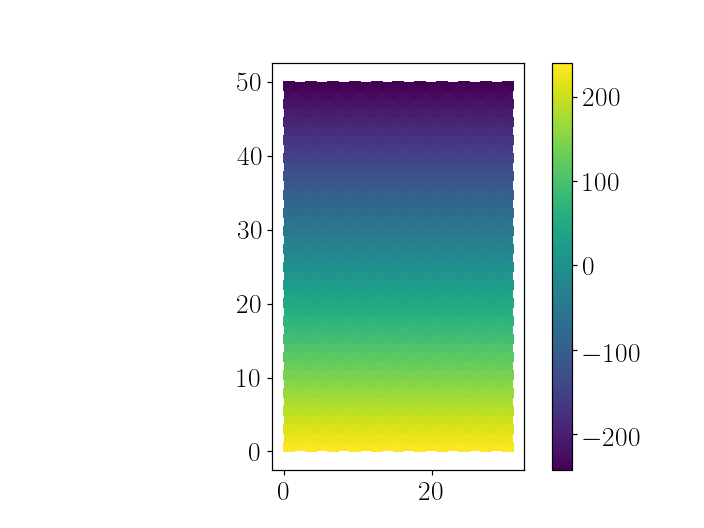

In [11]:
print(max(p0.vector()[:]))
print(min(p0.vector()[:]))

fig = plt.figure()
cb = plot(p0)
fig.colorbar(cb)
plt.show()

<IPython.core.display.Javascript object>


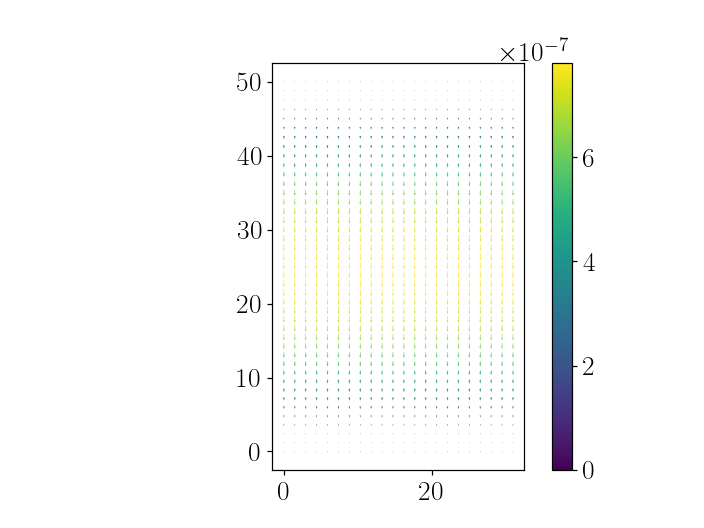

In [12]:
fig = plt.figure()
cb = plot(u0)
fig.colorbar(cb)
plt.show()

In [142]:
p_list = transient_darcy_flow(mesh_2d, boundary_markers, rho, dt_num = 1e-1, steps = 1)

490.33250000000646
Calling FFC just-in-time (JIT) compiler, this may take some time.
Integral of type cell cannot contain a ReferenceNormal.


UFLException: Integral of type cell cannot contain a ReferenceNormal.

319.02786342865267


<IPython.core.display.Javascript object>


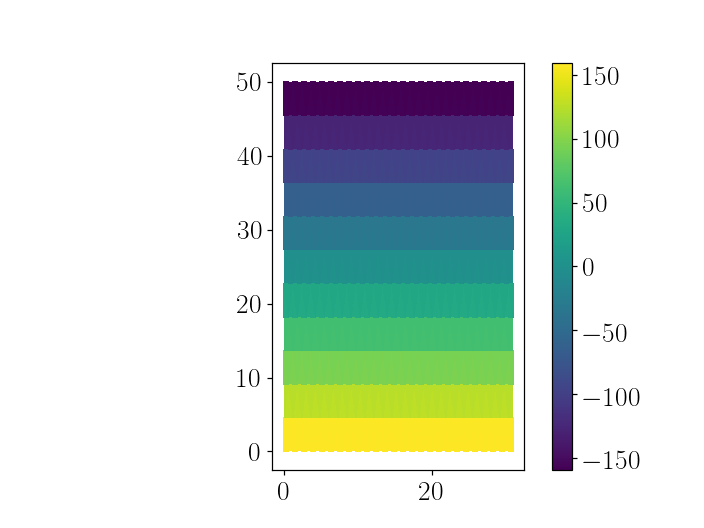

In [131]:
min_p = np.min(p_list[-1].vector()[:])
max_p = np.max(p_list[-1].vector()[:])

print(max_p-min_p)

fig = plt.figure()
cb = plot(p_list[-1])
fig.colorbar(cb)
plt.show()

<IPython.core.display.Javascript object>


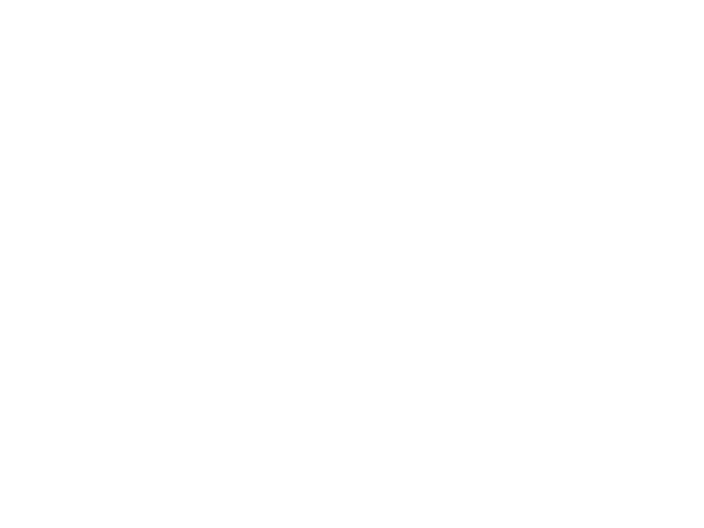

In [17]:
fig = plt.figure()
cb = plot(u0)
fig.colorbar(cb)
plt.show()

In [172]:
def potential_flow(mesh, boundary_markers, rho):
    W = FunctionSpace(mesh, 'CG', 1)
    CR = VectorFunctionSpace(mesh, 'DG', 0)
    
    #rho = project(Constant(1e-3), W)
    
    phi = Constant(1.0)
    K = Constant(1.0/48)  # aperture = 0.5 mm
    c = Constant(4e-10)   # Pa^-1
    mu = Constant(8.9e-4)
    g = Constant(-9806.65) # mm^2/s
    #adv = as_vector([0.0, -9806.65]) # gravity advection!
    adv = Constant((0.0, -9806.65))
    #adv = project(Constant( (0.0, -9806.65) ), RT)
    
#     plt.figure()
#     plot(adv)
#     plt.show()
    
    p_b = Constant(1e-3*9806.65*50)
    dt = Constant(dt_num)
    zero = Constant(0.0)
    
    p = TrialFunction(W)
    w = TestFunction(W)
    psi = Function(W)
    
    n = FacetNormal(mesh)
    
    x_ = interpolate(Expression("x[0]", degree=1), W)
    y_ = interpolate(Expression("x[1]",degree=1), W)

    Delta_h = sqrt(jump(x_)**2 + jump(y_)**2)
    
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
    dS = Measure('dS', domain=mesh, subdomain_data=boundary_markers)
    
    adv_np = ( dot ( adv, n ) + Abs ( dot ( adv, n ) ) ) / 2.0
    adv_nm = ( dot ( adv, n ) - Abs ( dot ( adv, n ) ) ) / 2.0
    adv_n = dot ( adv, n )
    
    p_list = []
    bc_list = [DirichletBC(W, zero, boundary_markers, 1),
               DirichletBC(W, zero, boundary_markers, 3),
               DirichletBC(W, zero, boundary_markers, 4),
               DirichletBC(W, zero, boundary_markers, 2)]
    
    F = inner(grad(w), grad(p))*dx + K/mu*g*w.dx(0)*rho*dx
        #jump(w)*jump(rho)*jump(p)/Delta_h*dS(0) + jump(w)*jump(rho)*avg(rho)*avg(adv_n)*dS(0)
        #- jump(w)*jump(rho)*(adv_np('+')*rho('+') + adv_nm('+')*rho('-'))*dS(0)
        #+ w*p/(50.0-y_)*ds(2) \
        #+ w*(p-p_b)/y_*ds(4)
    
    
#     F = w*phi*mu*c/K*p*dx + dot(jump(w, n), jump(p, n))/Delta_h*dS(0) \
#         + jump(rho)*dot(jump(w), adv_np('+')*p('+') + adv_np('-')*p('-') )*dS(0) \
#         + w*p/(50.0-y_)*ds(2) + w*(p-500.0)/y_*ds(4)
    
    a, L = lhs(F), rhs(F)
    
    #p = Function(W)
    
    problem = LinearVariationalProblem(a, L, psi, bcs=bc_list)
    solver = LinearVariationalSolver(problem)
    
    prm = solver.parameters

    prm['krylov_solver']['absolute_tolerance'] = 1e-14
    prm['krylov_solver']['relative_tolerance'] = 1e-12
    prm['krylov_solver']['maximum_iterations'] = 2000
    #if iterative_solver:
    prm['linear_solver'] = 'gmres'
    prm['preconditioner'] = 'amg'

    #for i in range(steps):
    solver.solve()
    
    return project(as_vector([psi.dx(1), -psi.dx(0)]), CR)

<IPython.core.display.Javascript object>


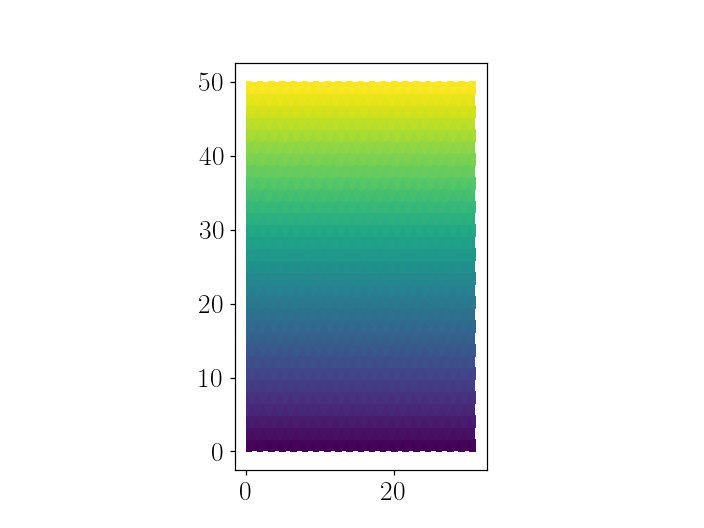

In [169]:
plt.figure()
plot(rho)
plt.show()

In [173]:
psi = potential_flow(mesh_2d, boundary_markers, rho)

<IPython.core.display.Javascript object>


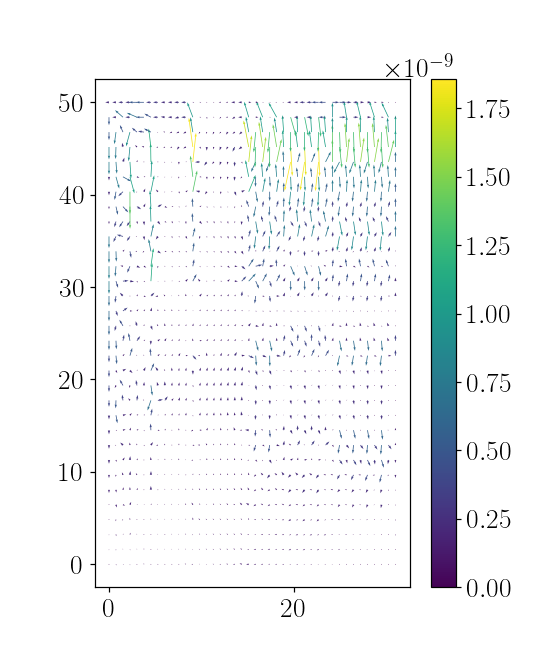

In [174]:
fig = plt.figure(figsize=(5,6))
#plot(mesh_2d)
cb = plot(psi)
fig.colorbar(cb)
plt.show()

<IPython.core.display.Javascript object>


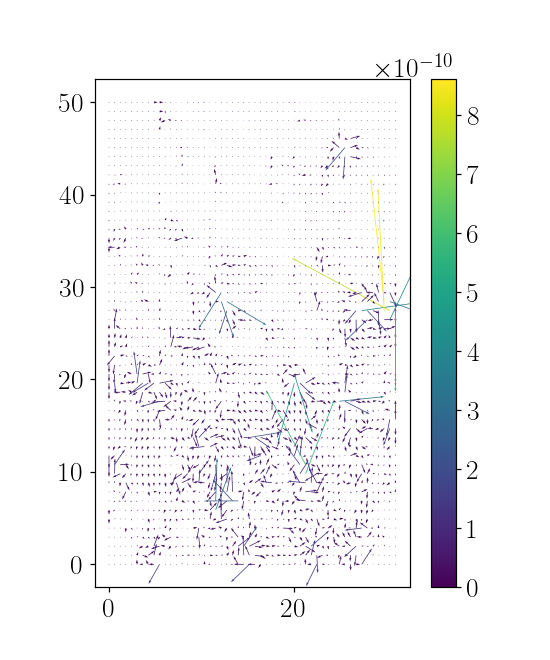

In [9]:
u_DG = project(div(u0), DG_space)
fig = plt.figure(figsize=(5,6))
#cb = plot(u_list[-1].sub(0))
cb = plot(u0)
#cb = plot(u_DG)
fig.colorbar(cb)
plt.show()

<IPython.core.display.Javascript object>


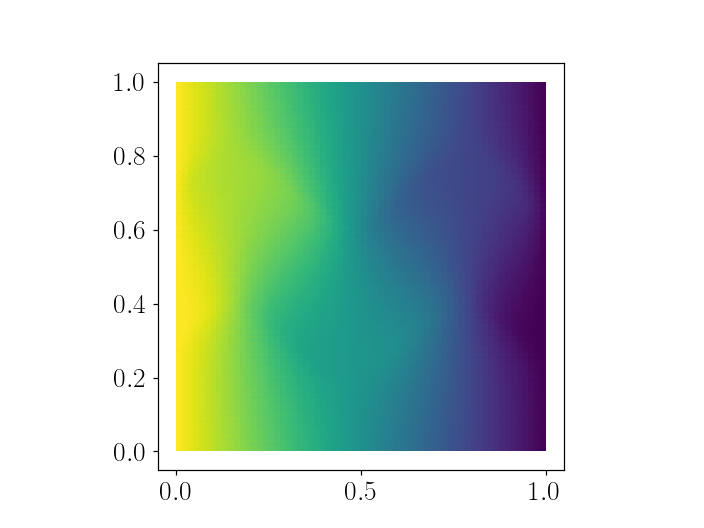

<IPython.core.display.Javascript object>


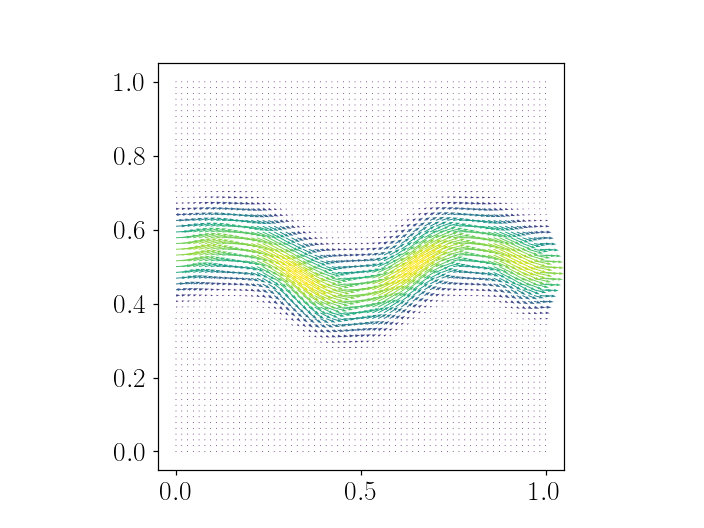

<IPython.core.display.Javascript object>


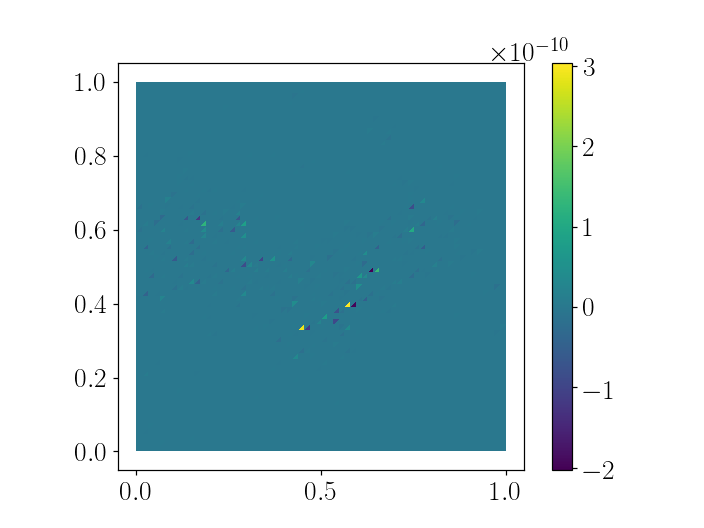

In [42]:
mesh = UnitSquareMesh(64, 64)
n = FacetNormal(mesh)

V = FiniteElement('RT', mesh.cell_name(), 1)
Q = FiniteElement('DG', mesh.cell_name(), 0)

DG_space = FunctionSpace(mesh, 'DG', 0)

X = FunctionSpace(mesh, MixedElement([V, Q]))

# define variational problem
u, p = TrialFunctions(X)
v, q = TestFunctions(X)
g = Constant(0)

k = MaxValue(Expression('exp(-pow((x[1]-0.5-0.1*sin(10*x[0]))/0.1, 2))', degree=1), Expression('0.01', degree=1))
mu = Constant(1)

# define boundary conditions
pD = Expression('1-x[0]', degree=1)

# a) variational problem
a = inner(mu/k*u, v)*dx - div(v)*p*dx - div(u)*q*dx
L = g*q*dx - dot(v,n)*pD*ds

# compute solution
xh = Function(X)
solve(a == L, xh)
uh, ph = xh.split(True)

# plot solution and write output files
plt.figure()
plot(ph)

plt.figure()
plot(uh)
#plt.write_png('step_06_u')

# b) plot the divergence of the velocity field
div_uh = project(div(uh), DG_space)
fig = plt.figure()
cb = plot(div_uh)
fig.colorbar(cb)
plt.show()
#plt.write_png('step_06_div_u')